In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import Imreduction, gp2idomain, gp2cellids,cellidBD, get_heads, get_spdis, get_MNTbbox, import_riv
from Rouss1 import inter_lst,get_cellcenters

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "workingDis"
model_name="first_2D"
exe_name="../../exe/mf6"

In [3]:
R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../data/MNT/MNT_50.tif"
Agly_path="../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path="../data/Fleuves/Tet_ludo.shp"

# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

In [4]:
#spatial parameters
Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = 50
nrow = 50
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -50
top = 10. # if no mnt is provided
idomain = np.zeros((nrow*ncol))

In [5]:
# import a mnt and extract topography data --> add it to top of the cells

"""
from PIL import Image
im = Image.open(MNT_path) # add path to MNT.tif
imar = np.array(im) # create an array
imar[imar==0]=None # None where it's nodata

top = Imreduction(imar,nrow,ncol)
"""

"\nfrom PIL import Image\nim = Image.open(MNT_path) # add path to MNT.tif\nimar = np.array(im) # create an array\nimar[imar==0]=None # None where it's nodata\n\ntop = Imreduction(imar,nrow,ncol)\n"

In [6]:
MNT = Raster.load(MNT_path)
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

top = dem_data = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")

In [7]:
R = gp.read_file(R_path) # import shapefile with geopandas

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=0)

In [8]:
### BC sea

# import the shapefile that correspond to the BC
BCsea_path = "../data/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")
# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))
chd_lst

[((0, 1, 45), 0),
 ((0, 1, 46), 0),
 ((0, 1, 47), 0),
 ((0, 1, 48), 0),
 ((0, 1, 49), 0),
 ((0, 2, 49), 0),
 ((0, 3, 49), 0),
 ((0, 4, 49), 0),
 ((0, 5, 49), 0),
 ((0, 6, 49), 0),
 ((0, 7, 48), 0),
 ((0, 7, 49), 0),
 ((0, 8, 48), 0),
 ((0, 9, 48), 0),
 ((0, 10, 48), 0),
 ((0, 11, 48), 0),
 ((0, 12, 48), 0),
 ((0, 13, 48), 0),
 ((0, 14, 48), 0),
 ((0, 15, 48), 0),
 ((0, 16, 47), 0),
 ((0, 16, 48), 0),
 ((0, 17, 47), 0),
 ((0, 18, 47), 0),
 ((0, 19, 47), 0),
 ((0, 20, 47), 0),
 ((0, 21, 47), 0),
 ((0, 21, 48), 0),
 ((0, 22, 48), 0),
 ((0, 23, 47), 0),
 ((0, 23, 48), 0),
 ((0, 24, 47), 0),
 ((0, 25, 47), 0),
 ((0, 26, 47), 0),
 ((0, 27, 47), 0),
 ((0, 28, 47), 0),
 ((0, 29, 47), 0),
 ((0, 30, 47), 0),
 ((0, 31, 47), 0),
 ((0, 32, 47), 0),
 ((0, 32, 48), 0),
 ((0, 33, 48), 0),
 ((0, 34, 48), 0),
 ((0, 35, 48), 0),
 ((0, 36, 48), 0),
 ((0, 37, 48), 0),
 ((0, 38, 48), 0),
 ((0, 39, 48), 0),
 ((0, 39, 49), 0),
 ((0, 40, 49), 0),
 ((0, 41, 49), 0)]

In [9]:
#BC Agly
BC_Agly = gp.read_file(Agly_path)
df_agy = import_riv(grid,BC_Agly)
df_agy.head()

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,cellids,lengths
0,"(0, 16, 29)",989.257030
1,"(0, 16, 30)",545.274488
2,"(0, 17, 30)",919.300705
3,"(0, 17, 31)",1006.300143
4,"(0, 17, 32)",1090.716698


In [10]:
#drop cellids which are already constant head
a = inter_lst(df_agy.cellids, lst_chd)
for i in range (len(a)):
    df_agy = df_agy.drop(df_agy[df_agy["cellids"] == a[i]].index)


# assign heads along the river
lst_Agy_long = np.array(df_agy.lengths) # make an array
H_us = 30 # head up stream
H_ds = 0 # head down stream
dh_dl = (H_ds-H_us)/lst_Agy_long.sum() #slope of the head along the river (linear interpolation)

H_riv = np.zeros(lst_Agy_long.shape[0], dtype=np.float) # initiate an array for the head in the river

for idx in range(lst_Agy_long.shape[0]): # loop for calculating the heads (can also be used for interpolate the botm of the river)
    if idx == 0:
        len_cum = 0.5 * lst_Agy_long[0]
    else:
        len_cum += 0.5 * (lst_Agy_long[idx-1]+lst_Agy_long[idx])
    H_riv[idx] = H_us + len_cum * dh_dl


Agy_chd=[]; o =-1;
for x in df_agy.cellids:
    o = o + 1
    Agy_chd.append((x,H_riv[o]))

In [11]:
# BC Tet
gp_Tet = gp.read_file(Tet_path)
df_tet = import_riv(grid,gp_Tet)

#drop cellids which are already constant heads
a = inter_lst(df_tet.cellids, lst_chd)
for i in range (len(a)):
    df_tet = df_tet.drop(df_tet[df_tet["cellids"] == a[i]].index)


# assign heads along the river
lst_riv_long = np.array(df_tet.lengths) # make an array
H_us = 160 # head up stream
H_ds = 0 # head down stream
dh_dl = (H_ds-H_us)/lst_riv_long.sum() #slope of the head along the river (linear interpolation)

H_riv = np.zeros(lst_riv_long.shape[0], dtype=np.float) # initiate an array for the head in the river

for idx in range(lst_riv_long.shape[0]): # loop for calculating the heads (can also be used for interpolate the botm of the river)
    if idx == 0:
        len_cum = 0.5 * lst_riv_long[0]
    else:
        len_cum += 0.5 * (lst_riv_long[idx-1]+lst_riv_long[idx])
    H_riv[idx] = H_us + len_cum * dh_dl


Tet_chd=[]; o =-1;
for x in df_tet.cellids:
    o = o + 1
    Tet_chd.append((x,H_riv[o]))



In [12]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf)

# nodeflowproperty
kh = 1e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True)

#recharge
mm = 100
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = mm/1000/365/86400)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='chd', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                               stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

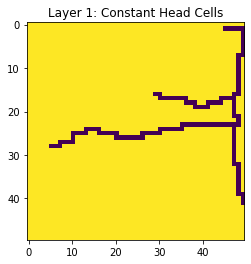

In [13]:
# vizualize the BC cells
iper = 0
ibd = np.ones((nlay, nrow, ncol), dtype=np.int)

ra = chd.stress_period_data.get_data(key=iper)
rb = Riv1.stress_period_data.get_data(key=iper)
rc = Riv2.stress_period_data.get_data(key=iper)

for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1
    
for k, i, j in rb['cellid']:
    ibd[k, i, j] = -1

for k, i, j in rc['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Constant Head Cells'.format(ilay + 1))

In [14]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model first_2D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package chd...
    writing package agy...
    writing package tet...


In [15]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

In [16]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

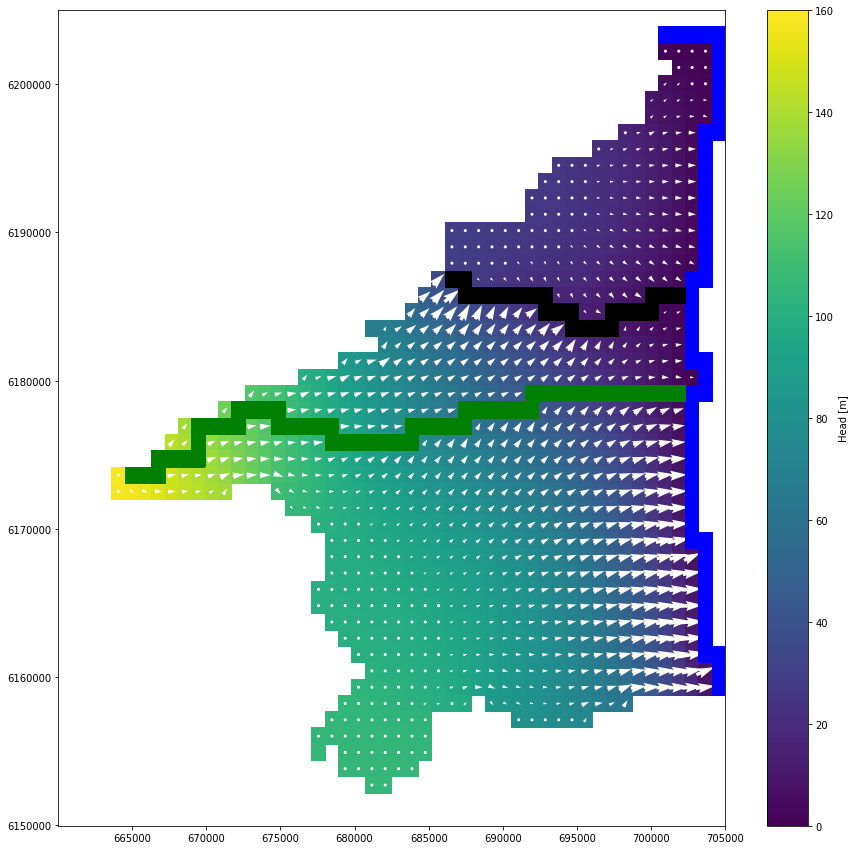

In [17]:
# make a plot

fig = plt.figure(figsize=(15,15))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

#hmesh=ml.plot_ibound()
hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
ml.plot_bc("chd",color="b")
ml.plot_bc("Tet",color="g")
riv2 = ml.plot_bc("Agy")
g=plt.colorbar(hmesh)
hmesh.set_clim((0,160))
g.set_label("Head [m]")

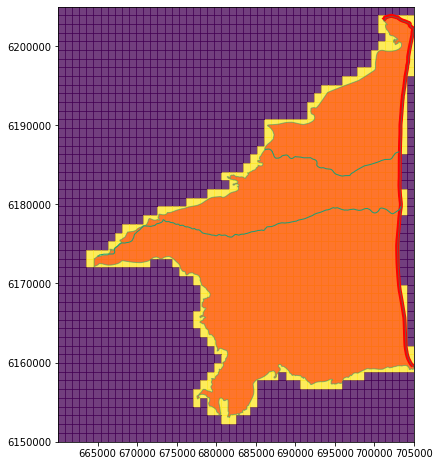

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(aspect='equal')

mm = fp.plot.PlotMapView(model=gwf)
#mm.plot_grid()
mm.plot_array(dis.idomain.array,alpha=0.5)
fp.plot.plot_shapefile(BCsea_path,ax=ax,edgecolor="r",facecolor="none",linewidth=4)
fp.plot.plot_shapefile(R_path,ax=ax,facecolor="Red",alpha=0.5)
fp.plot.plot_shapefile(Agly_path,ax=ax,facecolor="none")
fp.plot.plot_shapefile(Tet_path,ax=ax,facecolor="none")

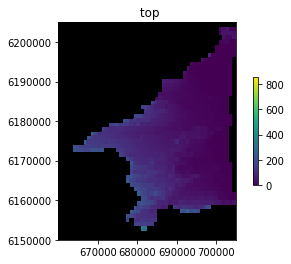

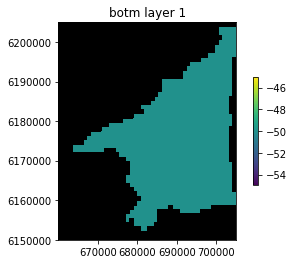

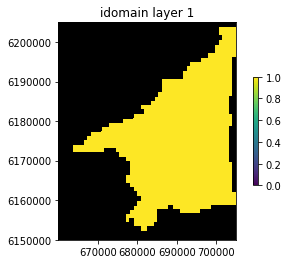

In [19]:
dis.plot()

In [20]:
# Total Budget
lstBudgetfile = "{}.lst".format(model_name)
fname = os.path.join(model_dir,lstBudgetfile)
Budgetobj = fp.utils.Mf6ListBudget(fname)

In [21]:
for i in Budgetobj.entries:
    print("{} : {}".format(i,Budgetobj.get_budget(names=i)[0][0][-1]))

RCH_IN : 2.797100067138672
CHD_IN : 1.1490000486373901
TOTAL_IN : 3.974600076675415
RCH_OUT : 0.0
CHD_OUT : 1.4930000305175781
TOTAL_OUT : 3.974600076675415
IN-OUT : 5.186800080991816e-06
PERCENT_DISCREPANCY : 0.0
